# Synthesis of GHRH

This is the experiment where I want to test this.

1. This
2. That
3. The other

## Problems

These problems occurred.


In [5]:
peptide = ["ala"]

In [10]:
import mechwolf as mw
from datetime import timedelta

# define vessels
hatu = mw.Vessel("HATU", name="hatu")
dmf = mw.Vessel("DMF", name="dmf")
output = mw.Vessel("waste", name="output")
diea = mw.Vessel("DIEA", name="diea")
pip = mw.Vessel("40% Piperidine in DMF", name="pip")

# define pumps
activator_pump = mw.VarianPump(name="activator_pump", serial_port = '/dev/serial/by-id/usb-FTDI_USB-RS422_Cable_FT1UI4UT-if00-port0')
amino_pump = mw.VarianPump(name="amino_pump", serial_port = '/dev/serial/by-id/usb-FTDI_USB-RS422_Cable_FT1UI4DV-if00-port0')
diea_pump = mw.VarianPump(name="diea_pump", serial_port = '/dev/serial/by-id/usb-FTDI_USB-RS422_Cable_FT1UI43N-if00-port0')

mixer = mw.TMixer(name='mixer')

# define sensors
uv = mw.LabJack(name="uv")

# define amines
fmoc_pna_a = mw.Vessel("fmoc_pna_a", name="fmoc_pna_a")
fmoc_pna_t = mw.Vessel("fmoc_pna_t", name="fmoc_pna_t")
fmoc_pna_c = mw.Vessel("fmoc_pna_c", name="fmoc_pna_c")
fmoc_pna_g = mw.Vessel("fmoc_pna_g", name="fmoc_pna_g")
fmoc_lys_oh = mw.Vessel("fmoc_lys_oh", name="fmoc_lys_oh")
syringe_6 = mw.Vessel("syringe_6", name="syringe_6")
ala = mw.Vessel("ala", name="ala")
leu = mw.Vessel("leu", name="leu")
phe = mw.Vessel("phe", name="phe")
# dummy passive heater
# heater = mw.Component("heater")

# define valve
amino_mapping = dict(fmoc_pna_a=1,
                     fmoc_pna_t=2,
                     fmoc_pna_c=3,
                     fmoc_pna_g=4,
                     fmoc_lys_oh=5,
                     syringe_6=6,
                     ala=7,
                     leu=8,
                     phe=9,
                     dmf=10)

amino_valve = mw.ViciValve(name="amino_valve", mapping=amino_mapping, serial_port = '/dev/serial/by-id/usb-FTDI_FT232R_USB_UART_AH06396Q-if00-port0')

act_mapping = dict(hatu=1,
                   pip=9,
                   dmf=10)

activator_valve = mw.ViciValve(name="activator_valve", mapping=act_mapping, serial_port = '/dev/serial/by-id/usb-FTDI_FT232R_USB_UART_AH06396Q-if00-port0')


def fat_tube(len):
    return mw.Tube(length=len, ID="1/16 in", OD="1/8 in", material="PFA")

def thin_tube(len):
    return mw.Tube(length=len, ID="0.030 in", OD="1/16 in", material="PFA")

def thinner_tube(len):
    return mw.Tube(length=len, ID="0.020 in", OD="1/16 in", material="PFA")


valve_tube = thinner_tube("12 cm")

A = mw.Apparatus("Peptide Nucleic Acid Synthesizer")

A.add(hatu, activator_valve, fat_tube("101 cm"))
A.add([dmf, pip], activator_valve, fat_tube("101 cm"))
A.add(activator_valve, activator_pump, valve_tube)
A.add(activator_pump, mixer, thinner_tube("46 cm"))
A.add(fmoc_pna_a, amino_valve, thin_tube("64.9 cm"))
A.add(fmoc_pna_t, amino_valve, thin_tube("53 cm"))
A.add(fmoc_pna_c, amino_valve, thin_tube("46.2 cm"))
A.add(fmoc_pna_g, amino_valve, thin_tube("44 cm"))
A.add(fmoc_lys_oh, amino_valve, thin_tube("36.1 cm"))
A.add(syringe_6, amino_valve, thin_tube("31 cm"))
A.add(ala, amino_valve, thin_tube("25.6 cm"))
A.add(leu, amino_valve, thin_tube("25 cm"))
A.add(phe, amino_valve, thin_tube("28.8 cm"))
A.add(dmf, amino_valve, fat_tube("113 cm"))
A.add(amino_valve, amino_pump, valve_tube)
A.add(amino_pump, mixer, thinner_tube("46 cm"))
A.add(diea, diea_pump, fat_tube("98 cm"))
A.add(diea_pump, mixer, thinner_tube("65 cm"))
A.add(mixer, uv, thinner_tube("40 cm"))

#A.describe()
#A.visualize(graph_attr=dict(splines="ortho", nodesep="0.75"), label_tubes=False)

P = mw.Protocol(A, duration="auto")
start = timedelta(seconds=0)

# how much time to leave the pumps off before and after switching the valve
switching_time = timedelta(seconds=1)



def pump_time(number_strokes, flow_rate=5):
    # Computes the length of time to run the Varian Prostar pump with a 5 mL/min pump head at the desired flow rate
    # to get the desired number of pump delivery cycles (pump strokes). The volume of each
    # pump stroke is 0.039239 mL.
    # Returns time in minutes.
    time_seconds = 60 * ((number_strokes * 0.039239) / flow_rate)
    return time_seconds


def add_rinse(time_seconds):
    global start
    rinse_duration = timedelta(seconds=time_seconds) + 2 * switching_time
    P.add([amino_valve, activator_valve], start=start, duration=rinse_duration, setting="dmf")
    P.add([amino_pump, activator_pump], start=start + switching_time, duration=rinse_duration - 2 * switching_time, rate="5 mL/min")
    start += rinse_duration


def add_diea_rinse(time_seconds):
    # Washes with all three pumps while coupling agent and amino acid flushes out
    global start
    rinse_duration = timedelta(seconds=time_seconds) + 2 * switching_time
    P.add([amino_valve, activator_valve], start=start, duration=rinse_duration, setting="dmf")
    P.add([amino_pump, activator_pump, diea_pump], start=start + switching_time, duration=rinse_duration - 2 * switching_time, rate="5 mL/min")

    start += rinse_duration

#######
P.add(uv, start = start, rate = "5 Hz")
add_rinse(10)
for amino in reversed(peptide):

    # Turn on amino acid, coupling agent, and diea. does not implement about a priming period
    coupling_duration = timedelta(seconds=(pump_time(number_strokes=10))) + 2 * switching_time

    P.add(amino_valve, start=start, duration=coupling_duration, setting=amino)
    P.add(activator_valve, start=start, duration=coupling_duration, setting="hatu")
    P.add([amino_pump, activator_pump, diea_pump], start=start + switching_time, duration=coupling_duration - 2 * switching_time, rate="5 mL/min")

    start += coupling_duration

    add_diea_rinse(pump_time(number_strokes=5))
    add_rinse(30)

    # Fmoc removal
    pip_addition_duration = timedelta(seconds=10) + 2 * switching_time

    P.add([amino_pump, activator_pump], start=start + switching_time, duration=pip_addition_duration - 2 * switching_time, rate="5 mL/min")
    P.add(amino_valve, start=start, duration=pip_addition_duration, setting="dmf")
    P.add(activator_valve, start=start, duration=pip_addition_duration, setting="pip")

    start += pip_addition_duration

    add_rinse(30)

add_rinse(10)
add_rinse(10)

print(P.yaml())

/home/pentelute/mechwolf/mechwolf/mechwolf.py:482: UserWarning: Automatically inferring stop for <LabJack uv> as the end of the protocol. To override, provide stop in your call to add(). To suppress this warning, use warnings=False.
  Fore.YELLOW + f"Automatically inferring stop for {procedure['component']} as the end of the protocol. To override, provide stop in your call to add(). To suppress this warning, use warnings=False.")


activator_pump:
- params: {rate: 5 mL/min}
  time: 1.0
- params: {rate: 0 mL/min}
  time: 11.0
- params: {rate: 5 mL/min}
  time: 13.0
- params: {rate: 0 mL/min}
  time: 17.70868
- params: {rate: 5 mL/min}
  time: 19.70868
- params: {rate: 0 mL/min}
  time: 22.06302
- params: {rate: 5 mL/min}
  time: 24.06302
- params: {rate: 0 mL/min}
  time: 54.06302
- params: {rate: 5 mL/min}
  time: 56.06302
- params: {rate: 0 mL/min}
  time: 66.06302
- params: {rate: 5 mL/min}
  time: 68.06302
- params: {rate: 0 mL/min}
  time: 98.06302
- params: {rate: 5 mL/min}
  time: 100.06302
- params: {rate: 0 mL/min}
  time: 110.06302
- params: {rate: 5 mL/min}
  time: 112.06302
- params: {rate: 0 mL/min}
  time: 122.06302
activator_valve:
- params: {setting: 10}
  time: 0.0
- params: {setting: 1}
  time: 12.0
- params: {setting: 10}
  time: 18.70868
- params: {setting: 10}
  time: 23.06302
- params: {setting: 9}
  time: 55.06302
- params: {setting: 10}
  time: 67.06302
- params: {setting: 10}
  time: 99.06

In [12]:
A.summarize()

+Components-------------+------------+
| Name                  | Type       |
+-----------------------+------------+
| DMF                   | Vessel     |
| amino_valve           | ViciValve  |
| HATU                  | Vessel     |
| leu                   | Vessel     |
| activator_valve       | ViciValve  |
| amino_pump            | VarianPump |
| activator_pump        | VarianPump |
| fmoc_lys_oh           | Vessel     |
| ala                   | Vessel     |
| 40% Piperidine in DMF | Vessel     |
| mixer                 | TMixer     |
| phe                   | Vessel     |
| fmoc_pna_c            | Vessel     |
| fmoc_pna_t            | Vessel     |
| diea_pump             | VarianPump |
| fmoc_pna_g            | Vessel     |
| fmoc_pna_a            | Vessel     |
| DIEA                  | Vessel     |
| syringe_6             | Vessel     |
| uv                    | LabJack    |
+-----------------------+------------+
+Tubing-----------+-----------------+--------------------+------

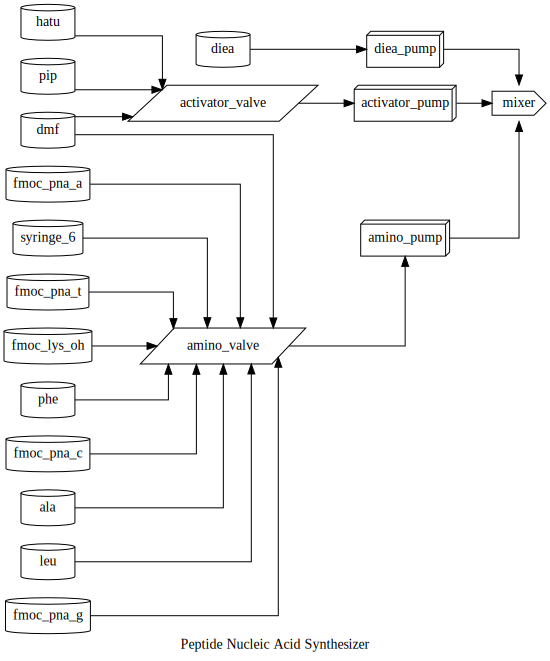

In [7]:
#Visualize the protocol
A.visualize()

In [11]:
P.visualize()

In [ ]:
#Returns immediately with an Experiment object that will update as it gets new data
Exp = jupyter_execute(P)

In [ ]:
#Visualize the experiment with live updating
Exp.visualize()

In [ ]:
#Inspect the protocol steps that ran successfully.
Exp.protocol.json()